# Question 7 and 8

## Loading data

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = utils.load_mnist_data()

In [4]:
x_test.shape    

torch.Size([10000, 1, 28, 28])

In [5]:
(x_train, y_train), (x_val, y_val) = utils.split_data(x_train_full, y_train_full)

## Implementing the network and training

### Utils

### Defining model and training procedure

### Training

In [6]:
# Train the model

model = utils.MNISTConvNet()
# Training on CPU (use "cuda" for GPU training if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# put the data on the device
x_train, y_train, x_val, y_val = x_train.to(device), y_train.to(device), x_val.to(device), y_val.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

first_epoch_running_loss, train_evaluations, val_evaluations = utils.train(model, x_train, y_train, x_val, y_val, optimizer, criterion, epochs=4, batch_size=16)
print(utils.count_parameters(model))


Batches for epoch 1/4: 100%|██████████| 3125/3125 [00:17<00:00, 176.46it/s]


Epoch 1/4, Train Loss: 0.0042, Train Acc: 0.9790, Val Loss: 0.0043, Val Acc: 0.9800


Batches for epoch 2/4: 100%|██████████| 3125/3125 [00:17<00:00, 179.02it/s]


Epoch 2/4, Train Loss: 0.0023, Train Acc: 0.9878, Val Loss: 0.0027, Val Acc: 0.9868


Batches for epoch 3/4: 100%|██████████| 3125/3125 [00:16<00:00, 184.23it/s]


Epoch 3/4, Train Loss: 0.0016, Train Acc: 0.9915, Val Loss: 0.0023, Val Acc: 0.9886


Batches for epoch 4/4: 100%|██████████| 3125/3125 [00:16<00:00, 192.63it/s]


Epoch 4/4, Train Loss: 0.0011, Train Acc: 0.9939, Val Loss: 0.0024, Val Acc: 0.9892
29066


## Plotting evaluation measures

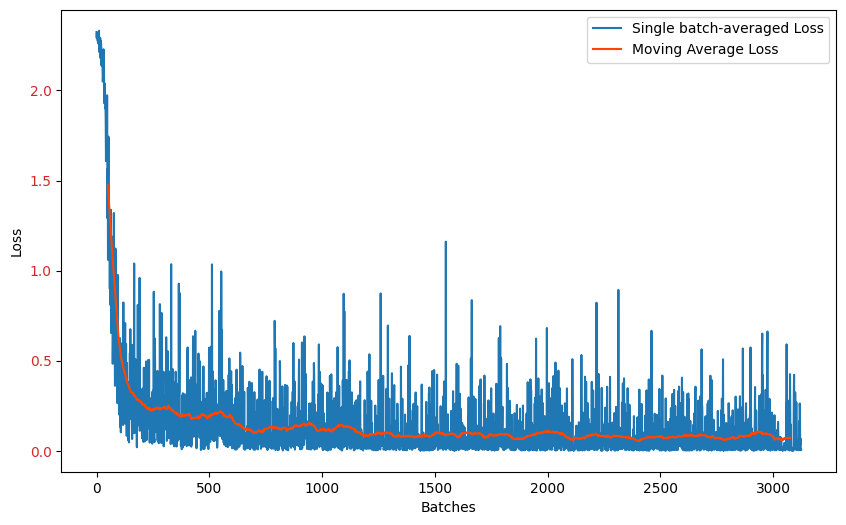

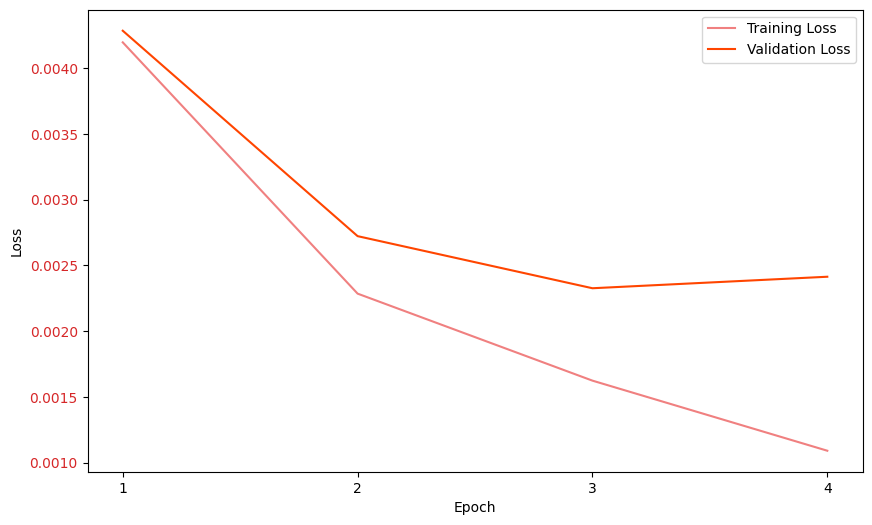

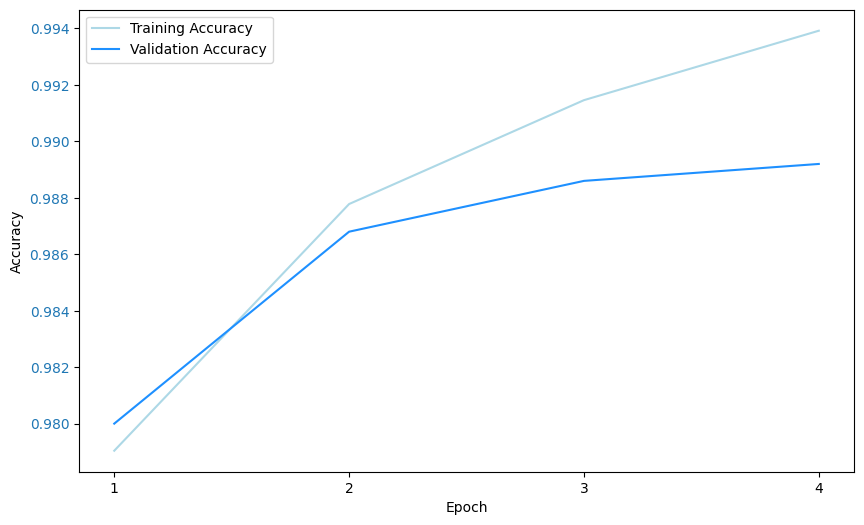

In [ ]:
utils.plot_results(first_epoch_running_loss, train_evaluations, val_evaluations)

# Question 11

## Max and Mean pooling

In [7]:
import torch  

b, c, h, w = 4, 10, 32, 32
x1 = torch.randn(b, c, h, w)
x2 = torch.randn(b, c, h*2, w*2)

x1_mean_pool = x1.mean(dim=(-2, -1))
x1_max_pool = x1.amax(dim=(-2, -1))
# Alteratively
# import torch.nn.functional as F
x1_max_pool_func = F.max_pool2d(x1, kernel_size=x1.size()[2:]).squeeze() # squeeze  because otherwise the shape would be (b, c, 1, 1)
print("x1_max_pool_func shape:", x1_max_pool_func.shape)  # should be (b, c)

x2_mean_pool = x2.mean(dim=(-2, -1))
x2_max_pool = x2.amax(dim=(-2, -1))

print("x1_mean_pool shape:", x1_mean_pool.shape)  # should be (b, c)
print("x1_max_pool shape:", x1_max_pool.shape)    # should be (b, c)

print("x2_mean_pool shape:", x2_mean_pool.shape)  # should be (b, c)
print("x2_max_pool shape:", x2_max_pool.shape)    # should be (b, c)

x1_max_pool_func shape: torch.Size([4, 10])
x1_mean_pool shape: torch.Size([4, 10])
x1_max_pool shape: torch.Size([4, 10])
x2_mean_pool shape: torch.Size([4, 10])
x2_max_pool shape: torch.Size([4, 10])


## Data Loading

For the code below to work you should add the decompressed minist_varres folder inside ./data/MNIST

In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Grayscale
import matplotlib.pyplot as plt


# Load the variable resolution dataset
varres_transform = Compose([  
    Resize((28, 28)),
    Grayscale(num_output_channels=1),
    ToTensor()
])

varres_test = ImageFolder(root='./data/MNIST/mnist-varres/test', transform=varres_transform)

vatters_train = ImageFolder(root='./data/MNIST/mnist-varres/train', transform=varres_transform)

# Split into training and validation sets
train_size = int(0.8 * len(vatters_train))
val_size = len(vatters_train) - train_size
train_varres_dataset, val_varres_dataset = torch.utils.data.random_split(vatters_train, [train_size, val_size])


# Create data loaders
train_varres_loader = DataLoader(train_varres_dataset, batch_size=len(train_varres_dataset), shuffle=True)
val_varres_loader = DataLoader(val_varres_dataset, batch_size=len(val_varres_dataset), shuffle=False)

test_varres_loader = DataLoader(varres_test, batch_size=len(varres_test), shuffle=False)


#load the whole dataset into tensors
x_train_resized, y_train_resized= next(iter(train_varres_loader))
x_val_resized, y_val_resized = next(iter(val_varres_loader))
x_test_resized, y_test_resized = next(iter(test_varres_loader))


KeyboardInterrupt: 

# Question 12

## Training

In [ ]:
# Train the model

model = utils.MNISTConvNet()
# Training on CPU (use "cuda" for GPU training if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# put the data on the device
x_train_resized, y_train_resized, x_val_resized, y_val_resized = x_train_resized.to(device), y_train_resized.to(device), x_val_resized.to(device), y_val_resized.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

first_epoch_running_loss, train_evaluations, val_evaluations = utils.train(model, x_train_resized, y_train_resized, x_val_resized, y_val_resized, optimizer, criterion, epochs=3, batch_size=64)

Batches for epoch 1/3:   0%|          | 0/750 [00:00<?, ?it/s]

Batches for epoch 1/3: 100%|██████████| 750/750 [00:15<00:00, 49.07it/s]


Epoch 1/3, Train Loss: 0.0068, Train Acc: 0.8717, Val Loss: 0.0068, Val Acc: 0.8751


Batches for epoch 2/3: 100%|██████████| 750/750 [00:14<00:00, 50.56it/s]


Epoch 2/3, Train Loss: 0.0041, Train Acc: 0.9244, Val Loss: 0.0043, Val Acc: 0.9220


Batches for epoch 3/3: 100%|██████████| 750/750 [00:14<00:00, 50.62it/s]


Epoch 3/3, Train Loss: 0.0031, Train Acc: 0.9421, Val Loss: 0.0033, Val Acc: 0.9357


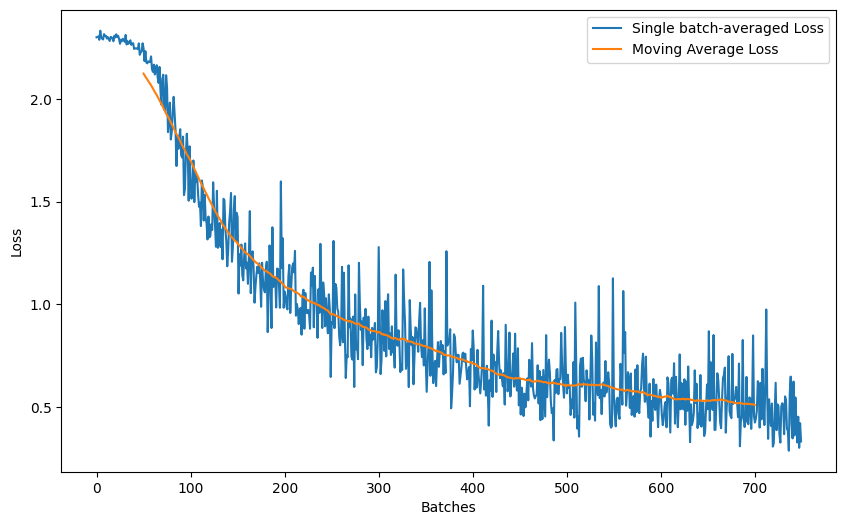

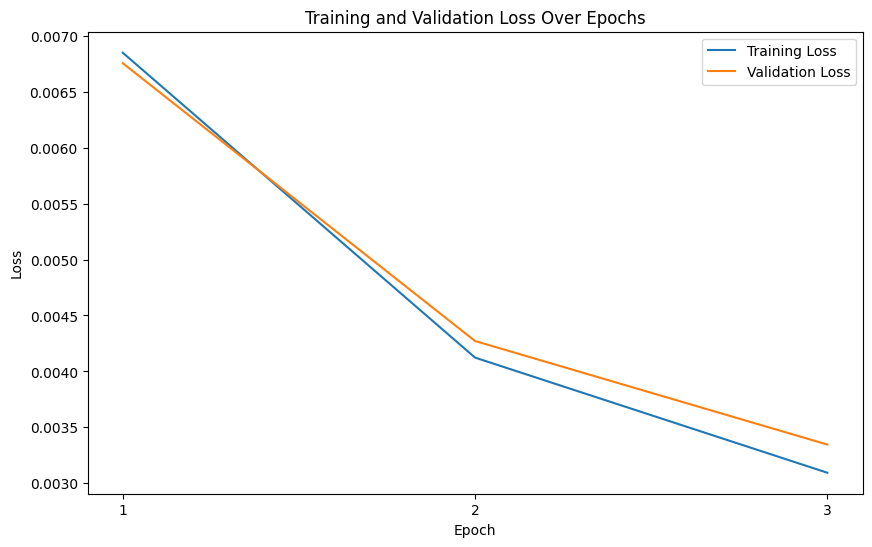

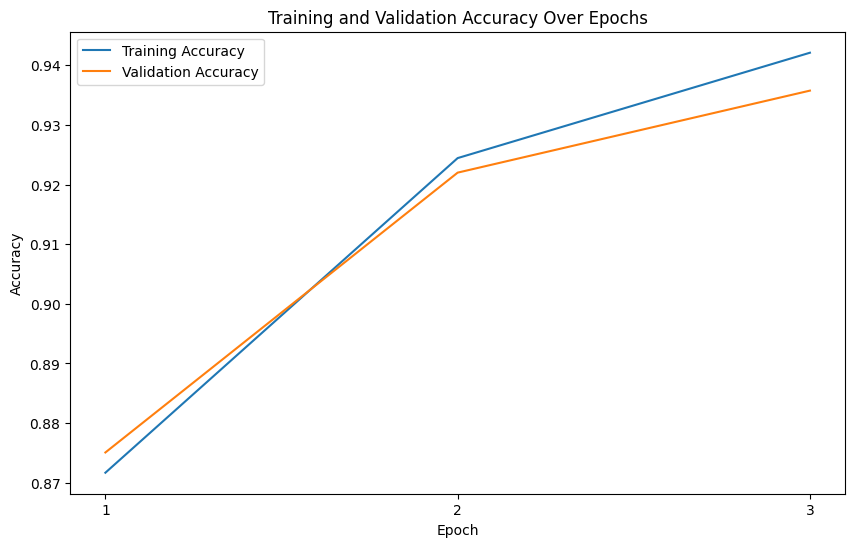

In [ ]:
import matplotlib.pyplot as plt

utils.plot_results(first_epoch_running_loss, train_evaluations, val_evaluations)